In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from pathlib import Path

DB_EPS = 40
DB_MIN_SAMPLES = 3

def frame_counts(csv_file, frames):
    spots = pd.read_csv(csv_file, skiprows=[1, 2, 3], low_memory=False)
    if not isinstance(frames, list):
        frames = [frames]
    counts = []
    for f in frames:
        counts.append(len(spots[spots["FRAME"] == f]))
    return counts

def frame_clusters_with_dbscan(csv_file, frame, db_eps=DB_EPS, db_min_sample=DB_MIN_SAMPLES):
    spots = pd.read_csv(csv_file, skiprows=[1, 2, 3], low_memory=False)
    spots_frame = spots[spots["FRAME"] == frame]
    pos_x = spots_frame["POSITION_X"].values
    pos_y = spots_frame["POSITION_Y"].values
    pos = np.vstack((pos_x, pos_y)).T
    if len(pos) == 0:
        return 0, pos, []
    clustering = DBSCAN(eps=DB_EPS, min_samples=DB_MIN_SAMPLES).fit(pos)
    num_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
    return num_clusters, pos, clustering.labels_

def plot_clusters(ax, img, frame, pos, labels):
    with tifffile.TiffFile(img) as tif:
        frame_img = tif.pages[frame*2].asarray()
    ax.imshow(frame_img, cmap="gray")
    for label in set(labels):
        if label == -1:
            continue
        cluster_pos = pos[labels == label]
        if len(cluster_pos) < 3:
            print("Skipping cluster with less than 3 points: ", img)
            continue
        hull = ConvexHull(cluster_pos)
        ax.plot(cluster_pos[hull.vertices, 0], cluster_pos[hull.vertices, 1], "r-")

def get_files_list(root):
    root = Path(root)
    return [root/f for f in os.listdir(root) if not f.startswith('.')]

In [4]:
PROJECT_ROOT = Path("/Users/ashkanhzdr/workspace/ViralTally")
DATASET_ROOT = PROJECT_ROOT / "dataset" / "Sars2Plaque"

dmso_csv_files = get_files_list(DATASET_ROOT / "trackmate" / "ACE2_A549_DMSO")
dmso_img_files = get_files_list(DATASET_ROOT / "processed" / "ACE2_A549_DMSO")

inhibitor_csv_files = get_files_list(DATASET_ROOT / "trackmate" / "ACE2_A549_inhibitor")
inhibitor_img_files = get_files_list(DATASET_ROOT / "processed" / "ACE2_A549_inhibitor")

In [5]:
images = [dmso_img_files, inhibitor_img_files]
csv_files = [dmso_csv_files, inhibitor_csv_files]
names = ["DMSO", "Inhibitor"]
frames = [0, 15, 30, 40, 45]

clusters = []

for g, group in enumerate(names):
    print(group)
    clusters.append([])
    for i, (img, csv) in enumerate(zip(images[g], csv_files[g])):
        frame_clusters = []
        for j, frame in enumerate(frames):
            num_cluster, pos, labels = frame_clusters_with_dbscan(csv, frame, db_eps=DB_EPS, db_min_sample=DB_MIN_SAMPLES)
            frame_clusters.append(num_cluster)
        clusters[g].append(frame_clusters)

DMSO
Inhibitor


counts for:  DMSO
/Users/ashkanhzdr/workspace/ViralTally/dataset/Sars2Plaque/trackmate/ACE2_A549_DMSO/D01_s1-all-spots.csv : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 223, 258, 281, 308, 326, 364, 378, 383, 386, 402, 379, 366, 360, 364, 355, 336, 336, 313, 304, 287, 275, 273, 256, 264, 236, 226, 212, 202, 193, 176, 184, 176, 172, 174]
/Users/ashkanhzdr/workspace/ViralTally/dataset/Sars2Plaque/trackmate/ACE2_A549_DMSO/E01_s4-all-spots.csv : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 468, 514, 537, 583, 633, 668, 710, 746, 743, 766, 792, 788, 766, 751, 744, 694, 662, 643, 623, 585, 568, 557, 534, 505, 485, 487, 462, 458, 418, 399, 377, 357, 327, 282]
/Users/ashkanhzdr/workspace/ViralTally/dataset/Sars2Plaque/trackmate/ACE2_A549_DMSO/A03_s3-all-spots.csv : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 329, 353, 390, 419, 440, 459, 499, 504, 510, 508, 526, 526, 523, 520, 512, 491, 464, 460, 438, 423, 408, 395, 370, 367, 352, 326, 297, 273, 270, 249, 245, 233, 225, 212]
/Users/ashkanhzdr/workspace/ViralTally/d

Text(0.5, 1.0, 'Inf Counts for every frame, every sample')

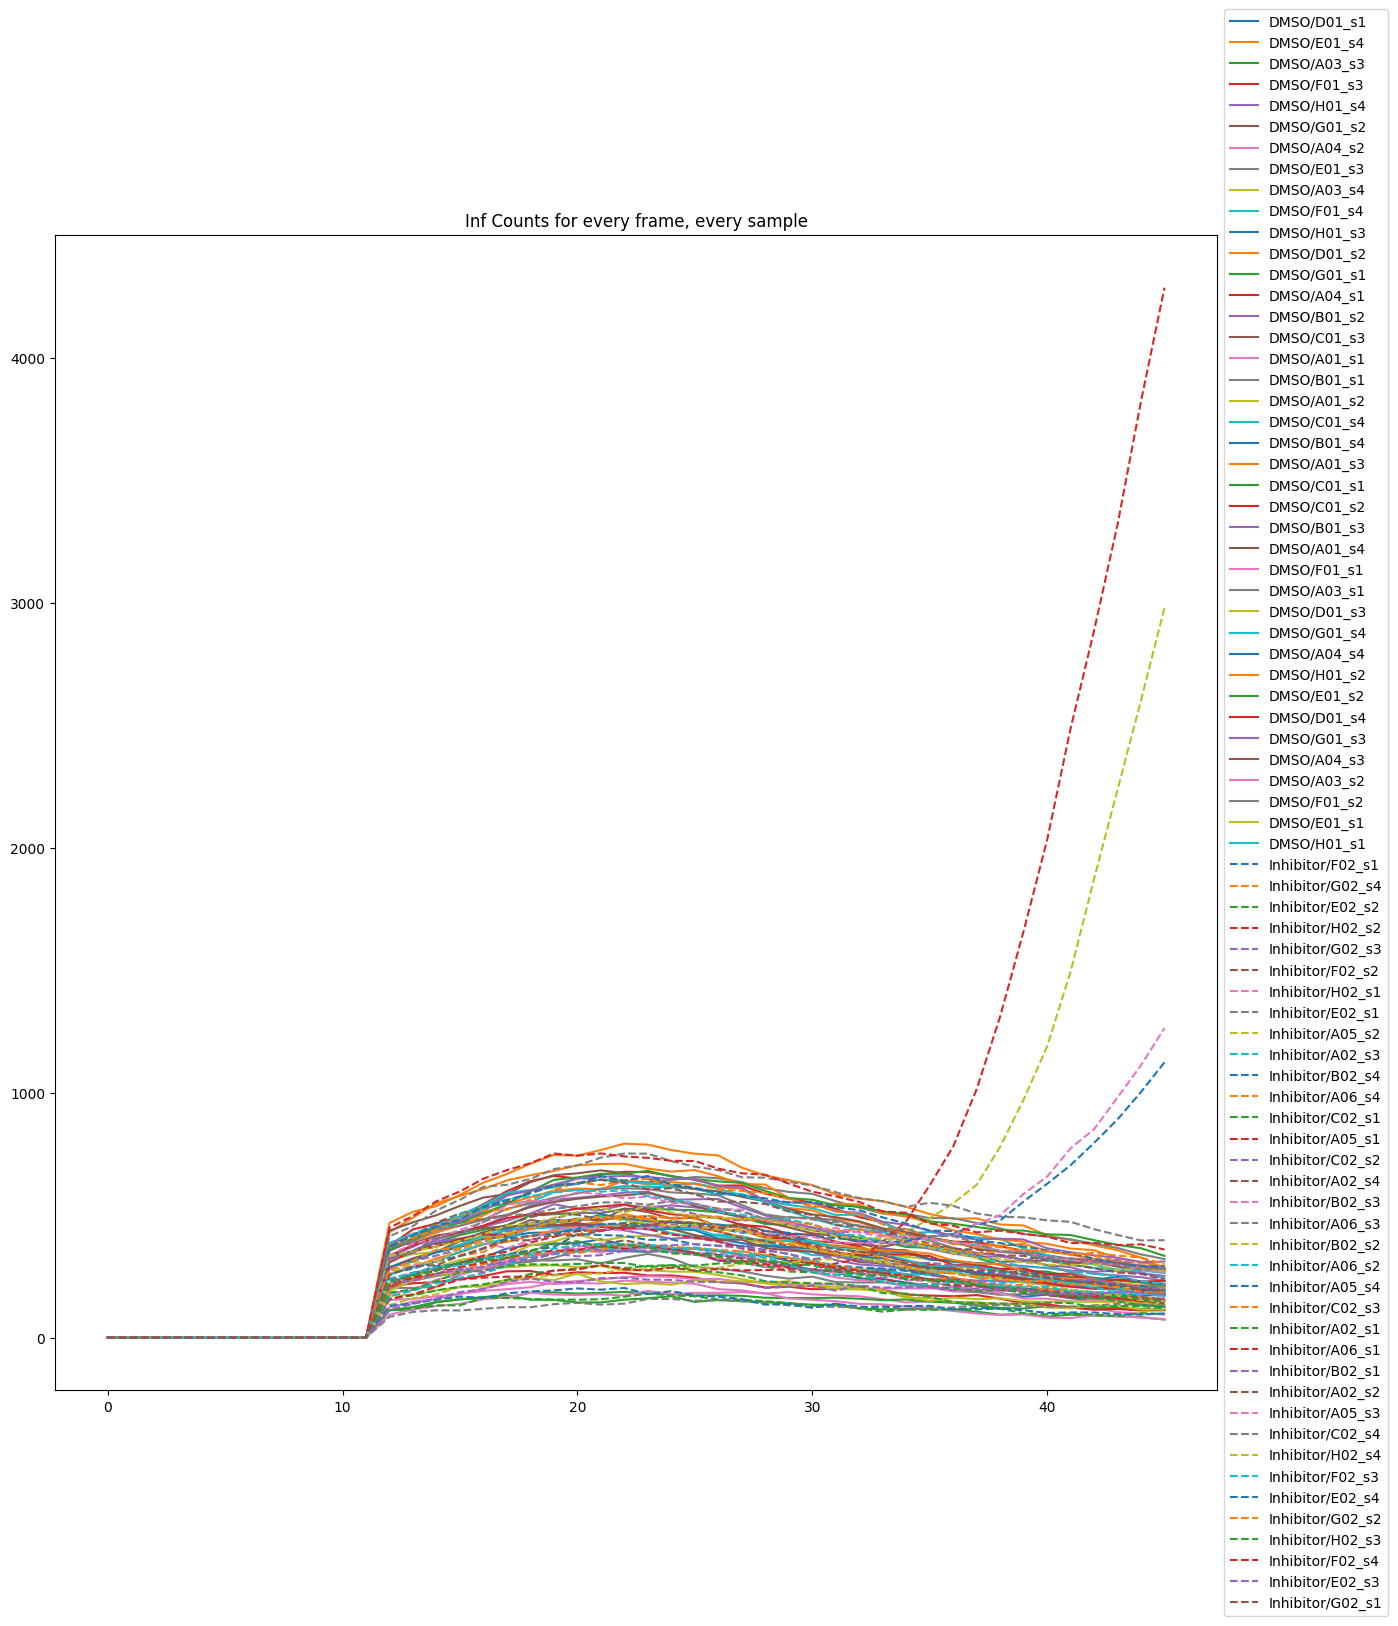

In [6]:
counts = []
for i, group_csv_files in enumerate(csv_files):
    print('counts for: ', names[i])
    counts.append([])
    for f in group_csv_files:
        c = frame_counts(f, list(np.arange(0, 46)))
        print(f, ':', c)
        counts[i].append(c)

linestyles = ['-', '--']
plt.figure(figsize=(15, 15))
for i, group_counts in enumerate(counts):
    linestyle = linestyles[i]
    for j in range(len(group_counts)):
        plt.plot(group_counts[j], label=names[i] + '/' + csv_files[i][j].name.split('-')[0], linestyle=linestyle)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Inf Counts for every frame, every sample")

In [7]:
NORMALIZING_FRAME = 1  # because frames when clusters calculated was frames = [15, 30, 45] and we want for 15
normalizing_clusters = [[l[NORMALIZING_FRAME] for l in cluster_group] for cluster_group in clusters]
print(normalizing_clusters)

[[39, 66, 50, 50, 64, 45, 23, 57, 49, 64, 36, 67, 23, 30, 46, 54, 20, 33, 44, 50, 42, 45, 23, 54, 43, 68, 16, 32, 38, 63, 48, 46, 43, 49, 51, 50, 32, 56, 22, 47], [39, 52, 20, 40, 37, 56, 33, 14, 28, 55, 57, 50, 27, 34, 31, 47, 52, 61, 49, 31, 44, 38, 34, 36, 28, 32, 48, 58, 50, 36, 22, 41, 35, 62, 27, 34]]


Text(0.5, 1.0, 'Normalized Inf Counts with clusters in frame 15')

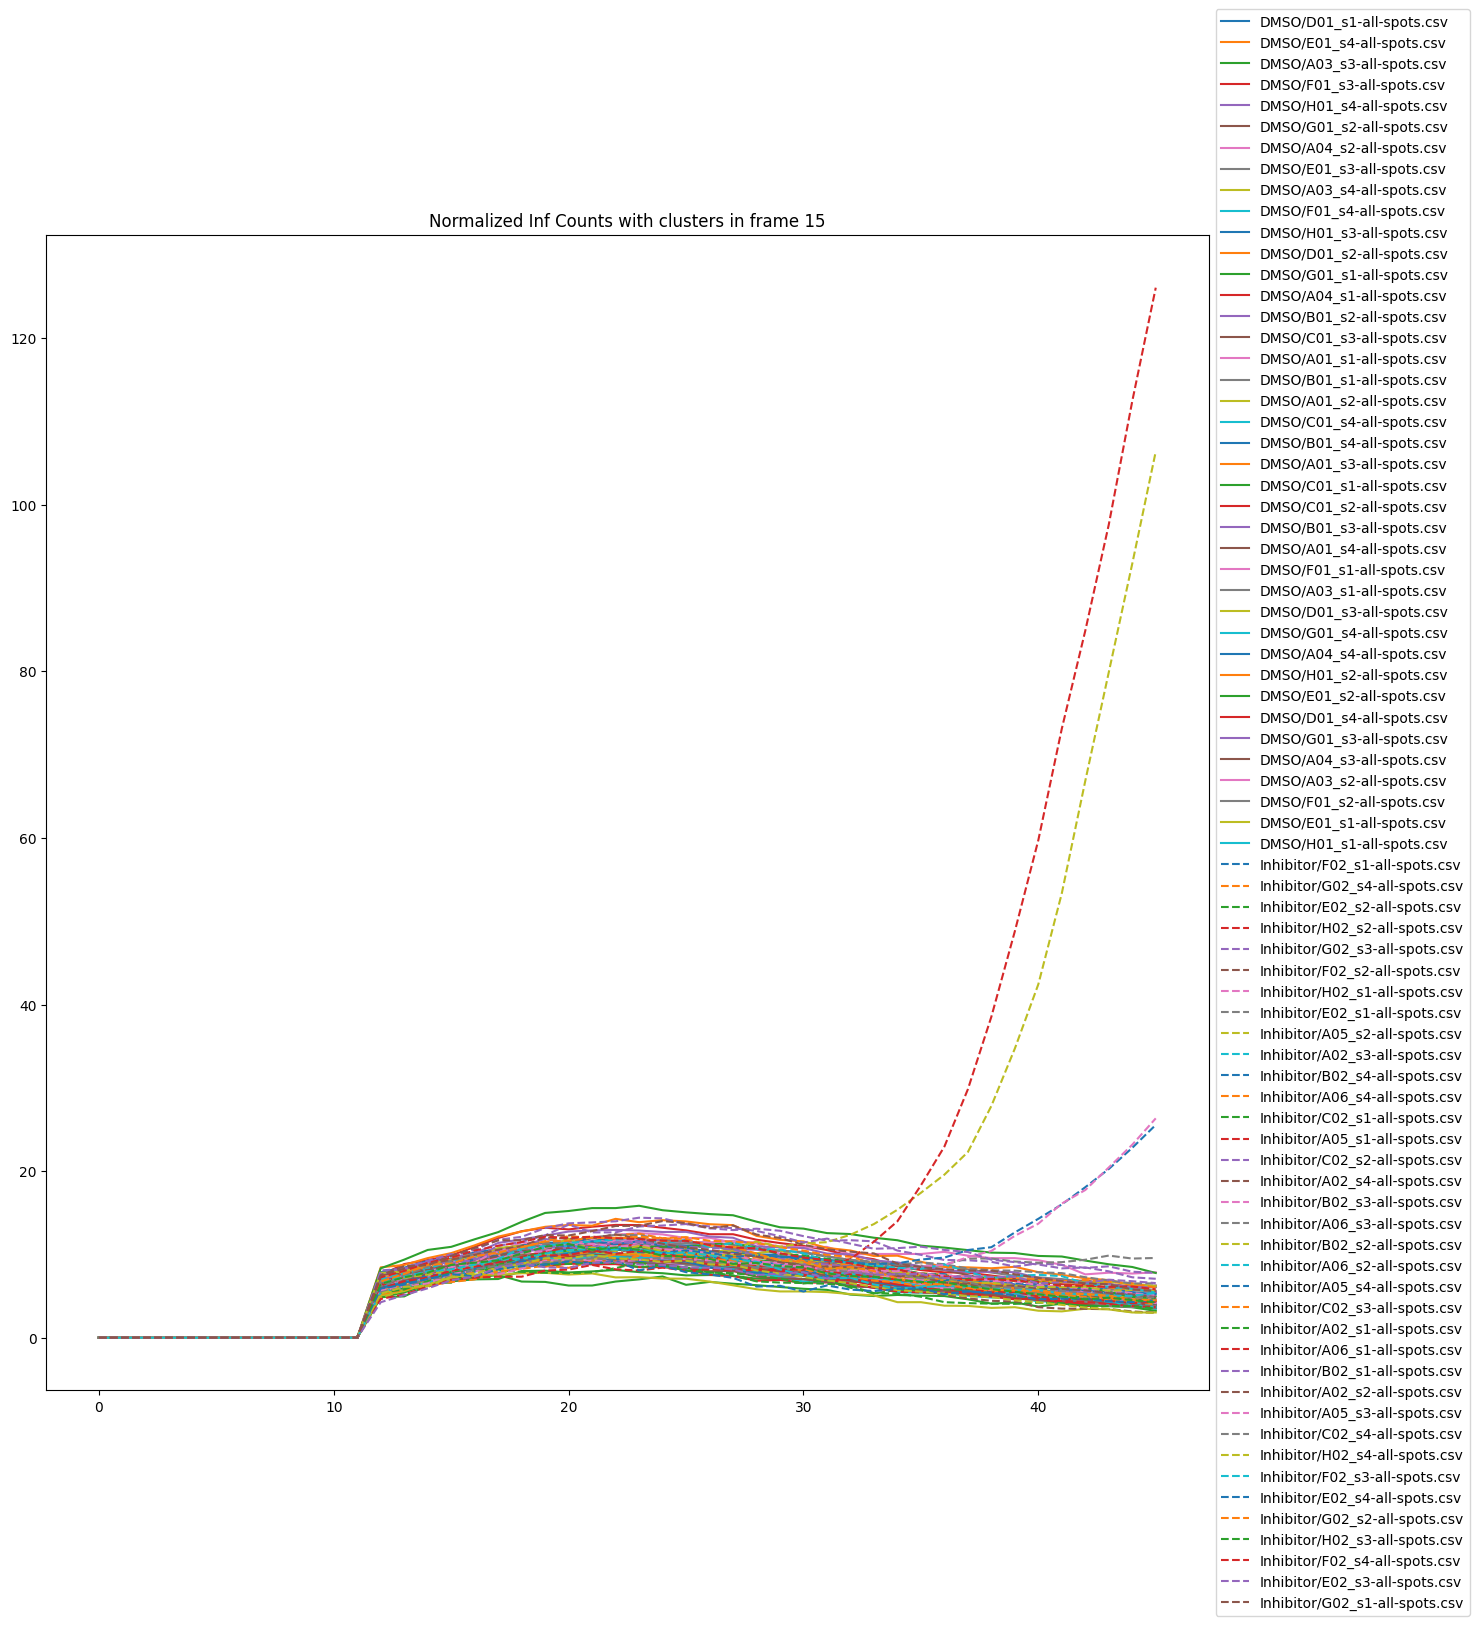

In [8]:
normalized_counts = []

plt.figure(figsize=(15, 15))
for g, group in enumerate(names):
    normalized_counts.append([])
    normalized_counts[g].extend([[c/num_cluster for c in cs] for (cs, num_cluster) in zip(counts[g], normalizing_clusters[g])])
    linestyle = linestyles[g]
    for i in range(len(normalized_counts[g])):
        plt.plot(normalized_counts[g][i], label=group + '/' + csv_files[g][i].name, linestyle=linestyle)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Normalized Inf Counts with clusters in frame " + str(frames[NORMALIZING_FRAME]))

time:  46
means:  46


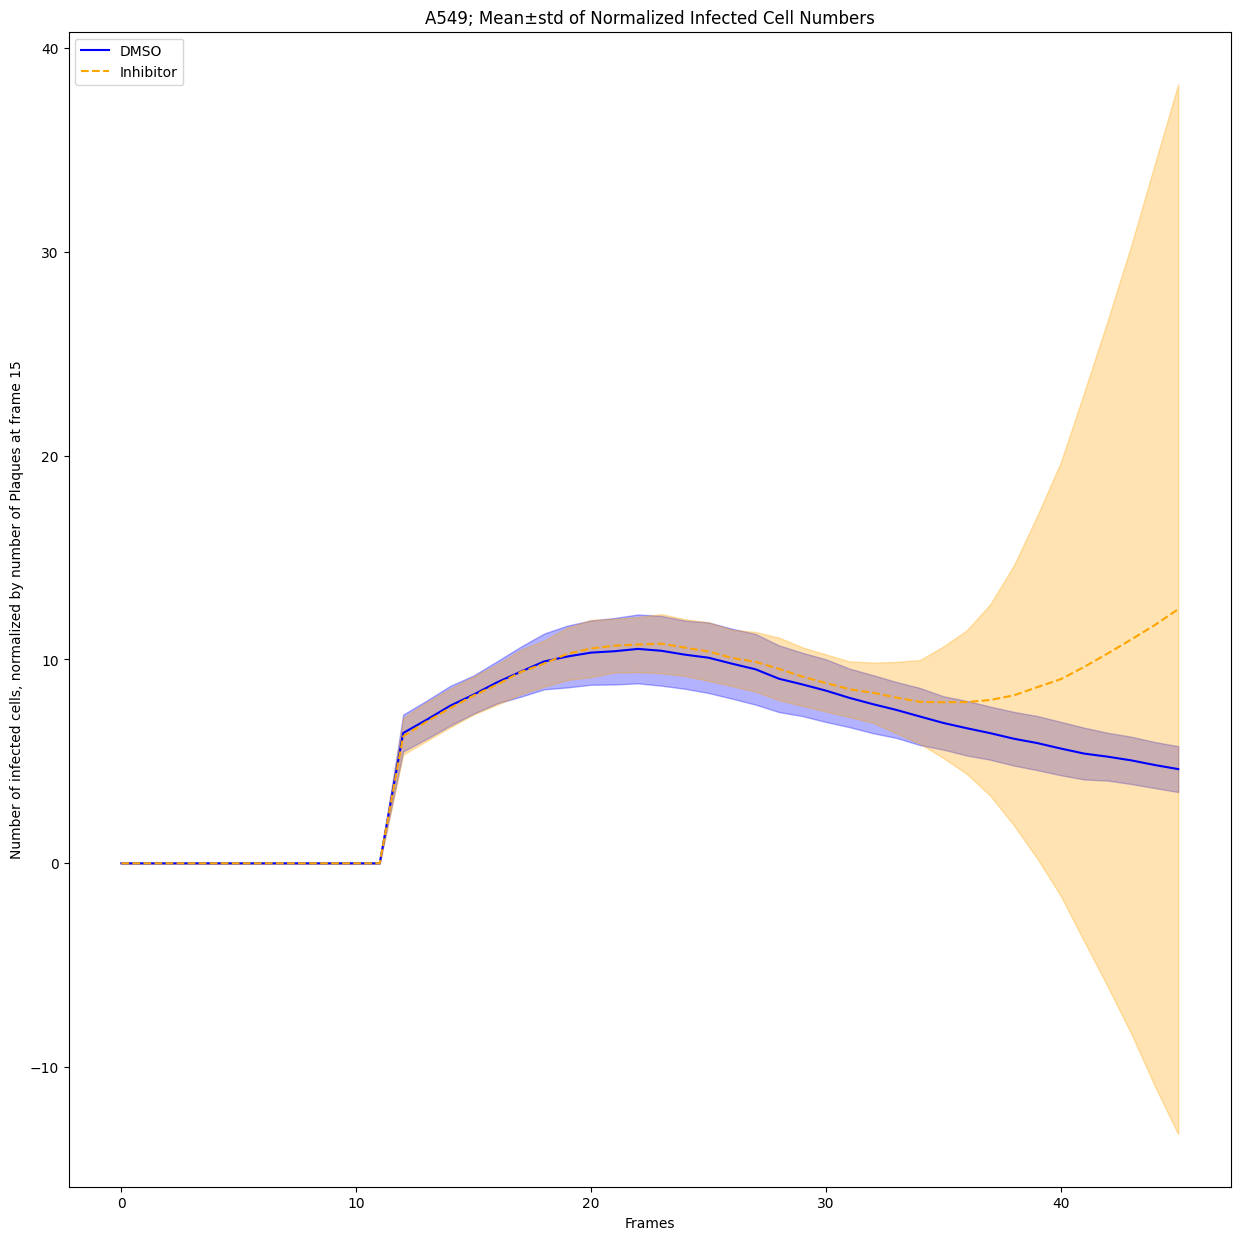

In [9]:
def plot_group_statistics(counts, timepoints, names, title, savepath=None):
    # Calculate mean and standard deviation for each group
    means = [np.mean(group_counts, axis=0) for group_counts in counts]
    stds = [np.std(group_counts, axis=0) for group_counts in counts]

    print('time: ', len(timepoints))
    print('means: ', len(means[0]))

    plt.figure(figsize=(15, 15))
    # Plot group statistics
    linestyles = ['-', '--']
    colors = ['blue', 'orange']
    for g in range(len(means)):
        plt.plot(timepoints, means[g], label=names[g], linestyle=linestyles[g], color=colors[g])
        plt.fill_between(timepoints, means[g] - stds[g], means[g] + stds[g], alpha=0.3, color=colors[g])
    
    # Add legend
    plt.xlabel('Frames')
    plt.ylabel('Number of infected cells, normalized by number of Plaques at frame 15')
    plt.title(title)
    plt.legend()
    
    # Show plot
    if savepath:
        plt.savefig(savepath, format="pdf")
    plt.show()

plot_group_statistics(normalized_counts, timepoints=np.arange(0, len(normalized_counts[0][0])), names=names, title="A549; Mean±std of Normalized Infected Cell Numbers")

# All together

In [10]:
def plot_group_statistics_all_together(csv_files, db_eps, db_min_sample, names, title, savepath=None):

    timepoints = np.arange(15, 46)

    # compute inf counts for all frames
    normalized_counts = []
    for csv_group in csv_files:
        normalized_counts_group = []
        for csv_file in csv_group:
            num_cluster, _, _ = frame_clusters_with_dbscan(csv_file, 15, db_eps, db_min_sample)
            counts = frame_counts(csv_file, list(timepoints))
            normalized_counts_group.append([c / num_cluster for c in counts])
        normalized_counts.append(normalized_counts_group)
    
    # Calculate mean and standard deviation for each group
    means = [np.mean(group_counts, axis=0) for group_counts in normalized_counts]
    stds = [np.std(group_counts, axis=0) for group_counts in normalized_counts]

    # Plot group statistics
    plt.figure(figsize=(15, 15))
    linestyles = ['-', '--', '*', '-*']
    colors = ['blue', 'orange', 'green', 'black']
    for g in range(len(means)):
        plt.plot(timepoints, means[g], label=names[g], linestyle=linestyles[g], color=colors[g])
        plt.fill_between(timepoints, means[g] - stds[g], means[g] + stds[g], alpha=0.3, color=colors[g])
    
    # Add legend
    plt.xlabel('Frames')
    plt.ylabel('Number of infected cells, normalized by number of Plaques at frame 15')
    plt.title(title)
    plt.legend()
    
    # Show plot
    if savepath:
        plt.savefig(savepath, format="pdf")
    plt.show()

# A549 Results

* D02_(s1,s2,s3,s4) samples are empty. So excluded here.

* a few of the inhibitor cases grow very quickly.

In [11]:
DB_EPS = 40
DB_MIN_SAMPLES = 3

PROJECT_ROOT = Path("/Users/ashkanhzdr/workspace/ViralTally")
DATASET_ROOT = PROJECT_ROOT / "dataset" / "Sars2Plaque"
SAVE_ROOT = PROJECT_ROOT / "output"
os.makedirs(SAVE_ROOT, exist_ok=True)

dmso_csv_files = get_files_list(DATASET_ROOT / "trackmate" / "ACE2_A549_DMSO")
inhibitor_csv_files = get_files_list(DATASET_ROOT / "trackmate" / "ACE2_A549_inhibitor")

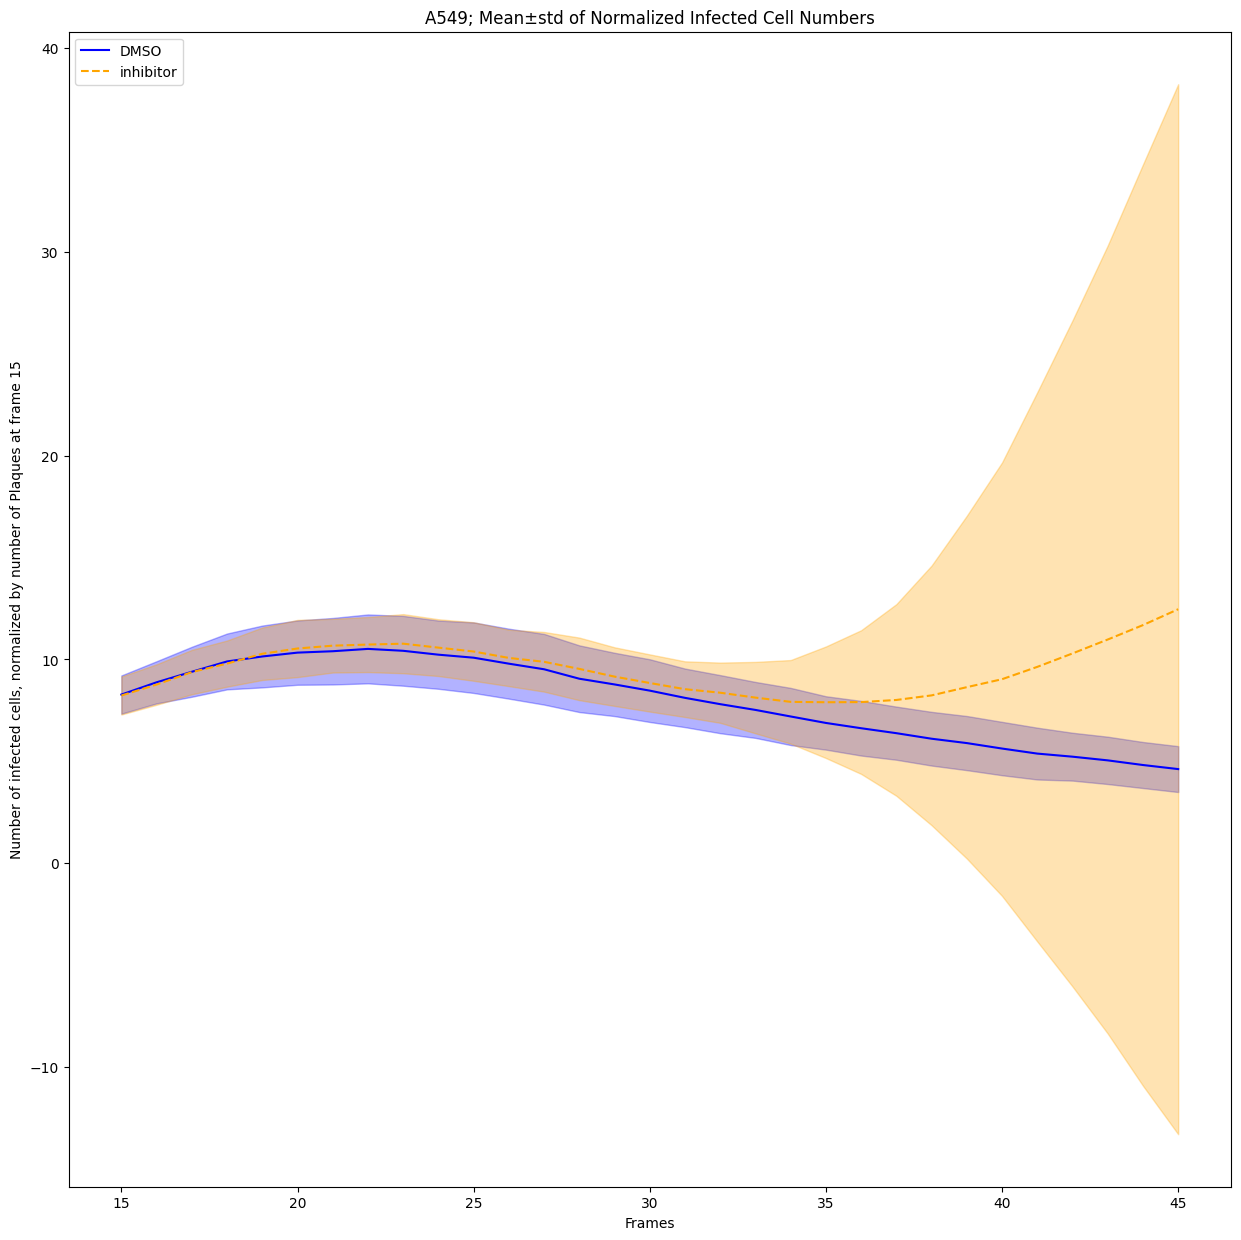

In [13]:
plot_group_statistics_all_together([dmso_csv_files, inhibitor_csv_files], DB_EPS, DB_MIN_SAMPLES, names=["DMSO", 'inhibitor'], title="A549; Mean±std of Normalized Infected Cell Numbers", savepath=SAVE_ROOT/'A549(wo-D02).pdf')

So after excluding these cases, we get the figure below.

Excluding the following samples: inhibitor/(A05_s2, A05_s1, A05_s4, A05_s3)

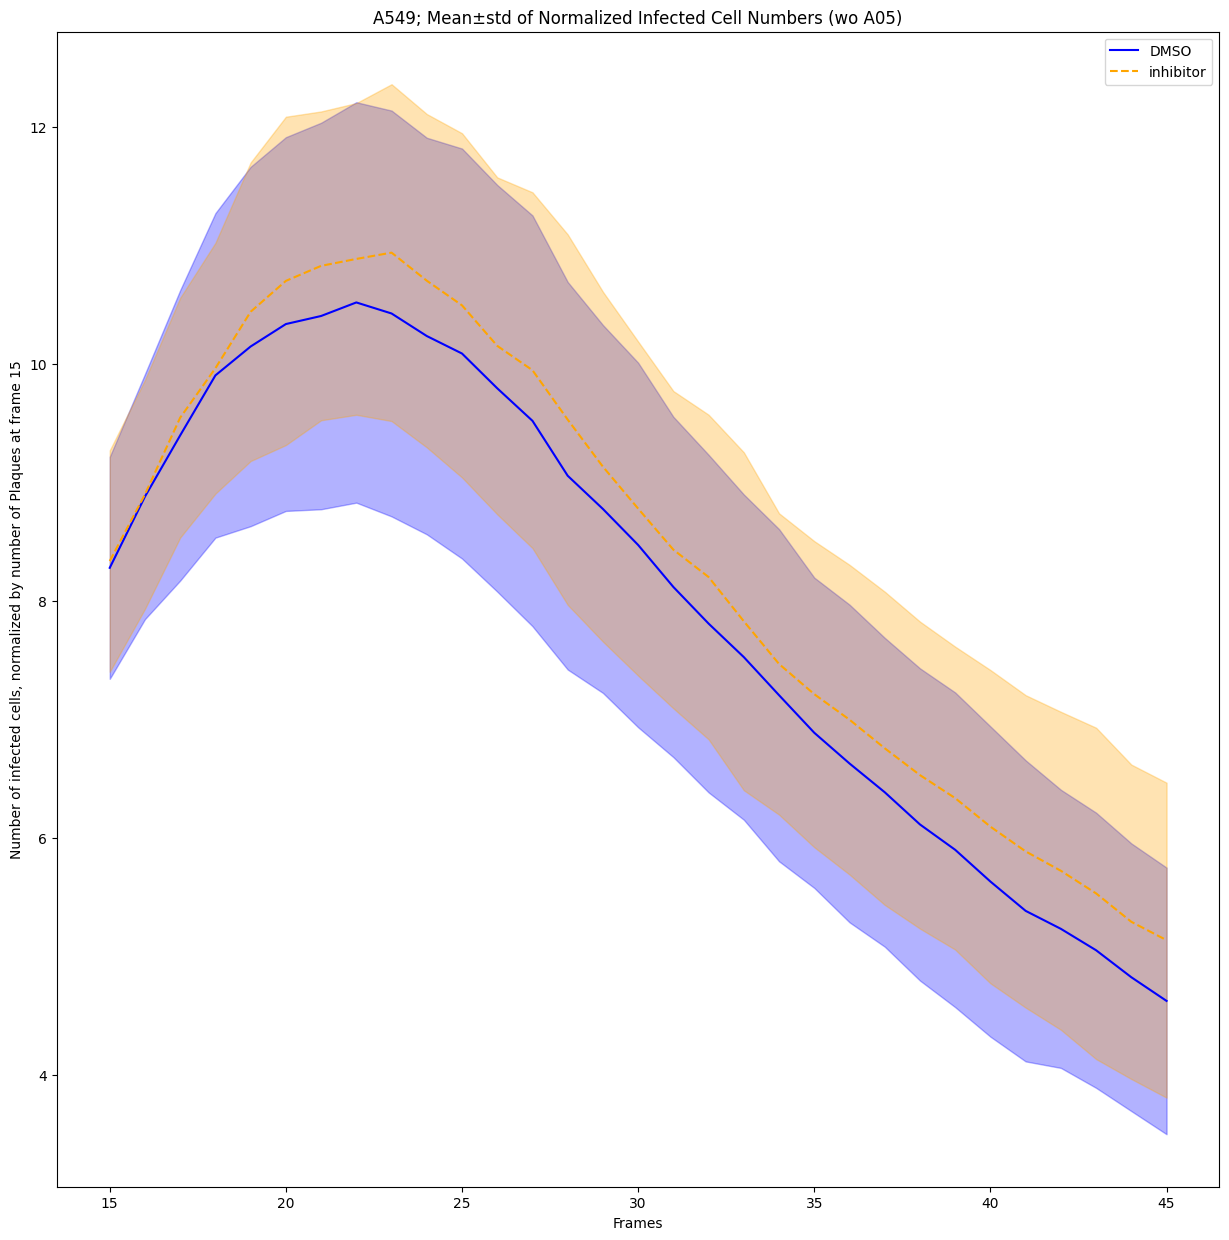

In [15]:
files_wo_outliers = [
    dmso_csv_files,
    [f for f in inhibitor_csv_files if 'A05' not in f.name]
]

plot_group_statistics_all_together(files_wo_outliers, DB_EPS, DB_MIN_SAMPLES, names=["DMSO", 'inhibitor'], title="A549; Mean±std of Normalized Infected Cell Numbers (wo A05)", savepath=SAVE_ROOT/'A549(wo-D02-A05).pdf')